In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score
from sklearn.utils import shuffle
from tqdm import tqdm_notebook as tqdm

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
np.random.seed(seed=42)

light_colors = [colors['lightcoral'], colors['lightgreen'], colors['lightblue']]
bayes_colors = [colors['black'], colors['gray'], colors['brown'], colors['white']]
point_colors = [colors['red'], colors['green'], colors['blue']]

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [2]:
def optimal_bayes(X, distrib):
    pdfs = np.array([g.pdf(X) for g in distrib]).T
    pred = np.argmax(pdfs, axis=1)
    return pdfs, pred

# Toy dataset 1 : Mixture of 3 Gaussians

In [98]:
gaussian1= multivariate_normal([1, 2], [[1, 0], [0, 2]])
gaussian2= multivariate_normal([4, 6], [[1, 0], [0, 2]])
gaussian3= multivariate_normal([-2, 4], [[1, 0], [0, 2]])
gaussians = [gaussian1, gaussian2, gaussian3]

TRAINING_SAMPLES = 5
TEST_SAMPLES = 100

In [99]:
# Generate training set
X_train = np.zeros((sum([TRAINING_SAMPLES for g in gaussians]),2))
Y_train = np.zeros(sum([TRAINING_SAMPLES for g in gaussians]))
cur = 0
for i,g in enumerate(gaussians):
    X_train[cur:cur+TRAINING_SAMPLES,:] = g.rvs(size=TRAINING_SAMPLES)
    Y_train[cur:cur+TRAINING_SAMPLES] = np.ones(TRAINING_SAMPLES)*i
    cur += TRAINING_SAMPLES

In [100]:
# Generate test set
X_test = np.zeros((sum([TEST_SAMPLES for g in gaussians]),2))
Y_test = np.zeros(sum([TEST_SAMPLES for g in gaussians]))
cur = 0
for i,g in enumerate(gaussians):
    X_test[cur:cur+TEST_SAMPLES,:] = g.rvs(size=TEST_SAMPLES)
    Y_test[cur:cur+TEST_SAMPLES] = np.ones(TEST_SAMPLES)*i
    cur += TEST_SAMPLES

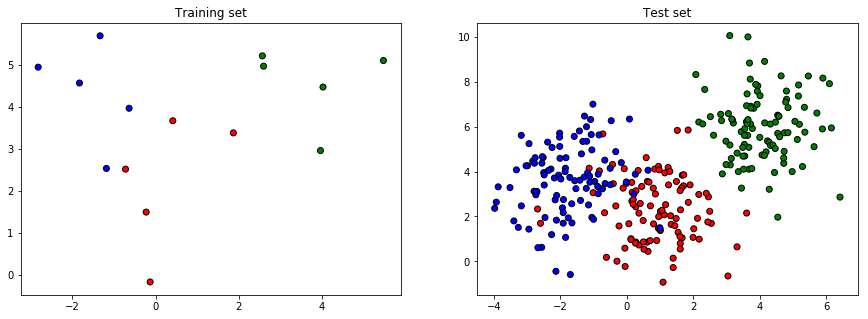

In [101]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.title('Training set')
plt.scatter(X_train.T[0], X_train.T[1], c=Y_train, cmap=matplotlib.colors.ListedColormap(point_colors), edgecolor='k')

plt.subplot(122)
plt.title('Test set')
plt.scatter(X_test.T[0], X_test.T[1], c=Y_test, cmap=matplotlib.colors.ListedColormap(point_colors), edgecolor='k')

plt.show()

In [102]:
classifier = LogisticRegression(random_state=0, solver='lbfgs',  multi_class='multinomial').fit(X_train, Y_train)

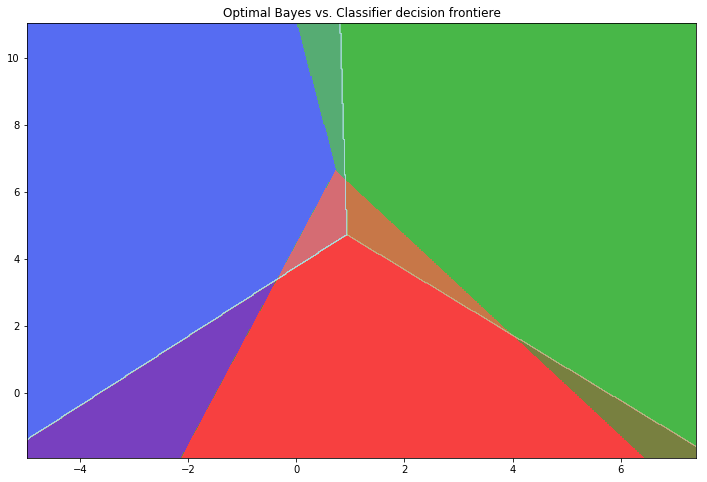

In [103]:
# Linspace for imshow plot
extend = (min(X_train[:,0].min(),X_test[:,0].min())-1, max(X_train[:,0].max(),X_test[:,0].max())+1, 
          min(X_train[:,1].min(),X_test[:,1].min())-1, max(X_train[:,1].max(),X_test[:,1].max())+1, )
xx, yy = np.meshgrid(np.arange(extend[0], extend[1], 0.02),
                         np.arange(extend[2], extend[3], 0.02))
Xfull = np.c_[xx.ravel(), yy.ravel()]

plt.figure(figsize=(12, 8))

# Classifier
Z = classifier.predict(Xfull)
Z = Z.reshape(xx.shape)

# Optimal bayes
proba_bayes, Z_bayes = optimal_bayes(Xfull, gaussians)
Z_bayes = Z_bayes

plt.title('Optimal Bayes vs. Classifier decision frontiere')
plt.contourf(xx, yy, Z_bayes.reshape(xx.shape), cmap=matplotlib.colors.ListedColormap(point_colors), alpha=1, linestyles='dotted')
plt.contourf(xx, yy, Z, alpha=0.5, cmap=matplotlib.colors.ListedColormap(light_colors), linestyles='dotted')

Accuracy classifier: 90.0% 
Accuracy optimal bayes: 95.0% 


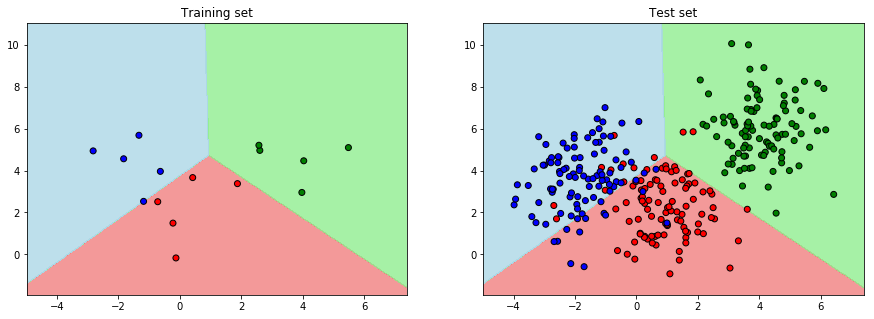

In [104]:
Y_pred = classifier.predict(X_test)
probas_pred = classifier.predict_proba(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy classifier: %0.1f%% " % (accuracy * 100))

proba_test_bayes, Y_bayes = optimal_bayes(X_test, gaussians)
accuracy = accuracy_score(Y_test, Y_bayes)
print("Accuracy optimal bayes: %0.1f%% " % (accuracy * 100))

plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.title('Training set')
plt.contourf(xx, yy, Z, cmap=matplotlib.colors.ListedColormap(light_colors), alpha=0.8)
plt.scatter(X_train.T[0], X_train.T[1], c=Y_train, cmap=matplotlib.colors.ListedColormap(point_colors), edgecolor='k')

plt.subplot(122)
plt.title('Test set')
plt.contourf(xx, yy, Z, cmap=matplotlib.colors.ListedColormap(light_colors), alpha=0.8)
plt.scatter(X_test.T[0], X_test.T[1], c=Y_test, cmap=matplotlib.colors.ListedColormap(point_colors), edgecolor='k')

plt.show()

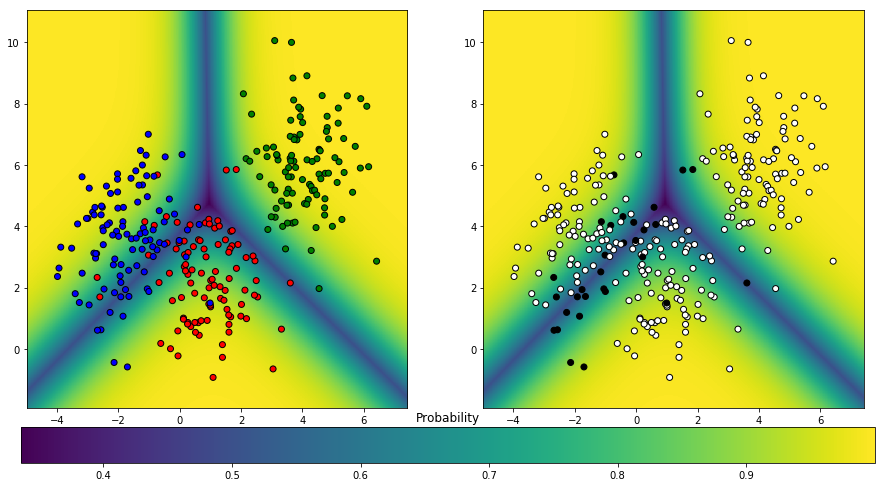

In [105]:
probas_grid = classifier.predict_proba(Xfull)

plt.figure(figsize=(15, 10))

plt.subplot(121)
imshow_handle = plt.imshow(probas_grid.max(axis=1).reshape(xx.shape), extent=extend, origin='lower')
plt.scatter(X_test.T[0], X_test.T[1], c=Y_test, cmap=matplotlib.colors.ListedColormap(point_colors), edgecolor='k')

plt.subplot(122)
plt.imshow(probas_grid.max(axis=1).reshape(xx.shape), extent=extend, origin='lower')
plt.scatter(X_test.T[0], X_test.T[1], c=(Y_pred==Y_test), cmap=matplotlib.colors.ListedColormap(['black','white']), edgecolor='k')

ax = plt.axes([0.12, 0.15, 0.79, 0.05])
plt.title("Probability")
plt.colorbar(imshow_handle, cax=ax, orientation='horizontal')
plt.show()

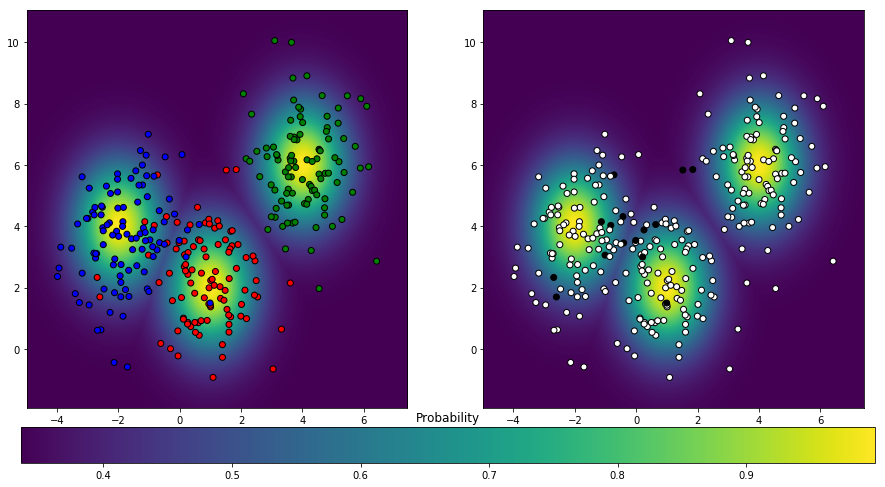

In [106]:
plt.figure(figsize=(15, 10))

plt.subplot(121)
plt.imshow(proba_bayes.max(axis=1).reshape(xx.shape), extent=extend, origin='lower')
plt.scatter(X_test.T[0], X_test.T[1], c=Y_test, cmap=matplotlib.colors.ListedColormap(point_colors), edgecolor='k')

plt.subplot(122)
plt.imshow(proba_bayes.max(axis=1).reshape(xx.shape), extent=extend, origin='lower')
plt.scatter(X_test.T[0], X_test.T[1], c=(Y_bayes==Y_test), cmap=matplotlib.colors.ListedColormap(['black','white']), edgecolor='k')

ax = plt.axes([0.12, 0.15, 0.79, 0.05])
plt.title("Probability")
plt.colorbar(imshow_handle, cax=ax, orientation='horizontal')
plt.show()

In [107]:
meshgrid_probas_true = np.choose(Z_bayes, probas_grid.T)

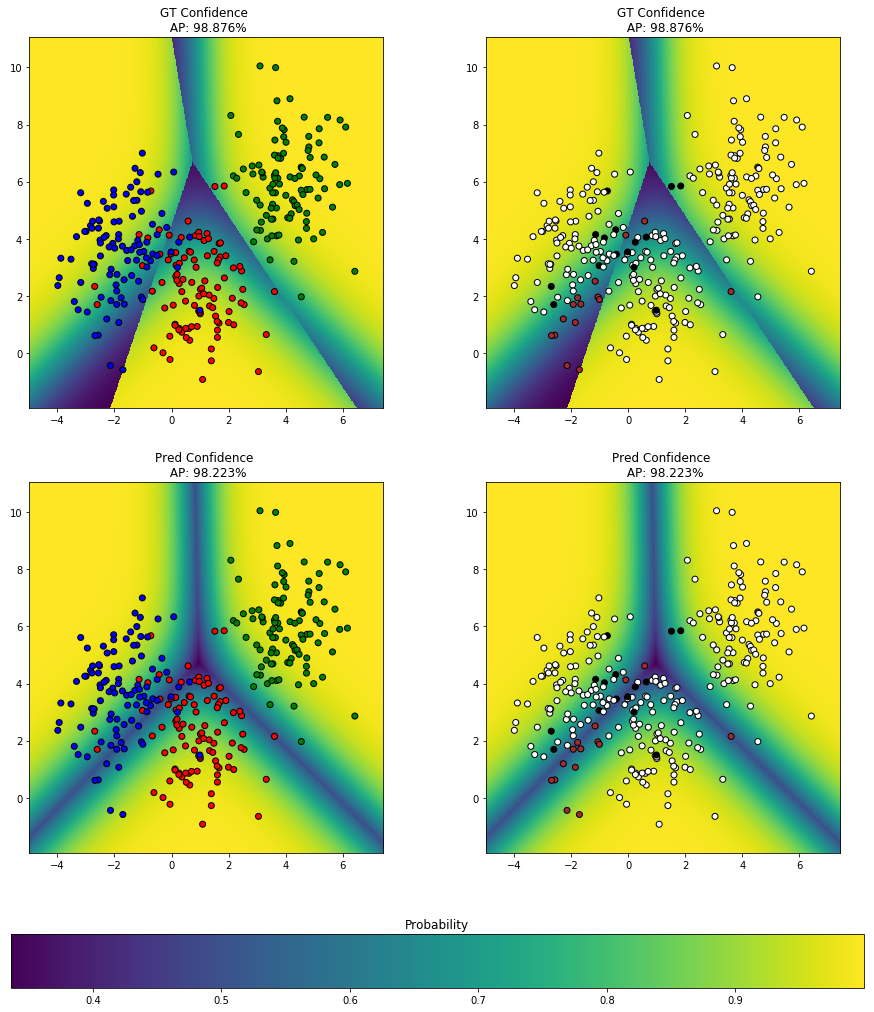

In [108]:
ap_pred = average_precision_score((Y_pred==Y_test),probas_pred.max(axis=1))
ap_gt = average_precision_score((Y_pred==Y_test),np.choose(Y_bayes, probas_pred.T))

plt.figure(figsize=(15, 15))

plt.subplot(221)
plt.title('GT Confidence \n AP: {:0.3%}'.format(ap_gt))
plt.imshow(meshgrid_probas_true.reshape(xx.shape), extent=extend, origin='lower')
plt.scatter(X_test.T[0], X_test.T[1], c=Y_test, cmap=matplotlib.colors.ListedColormap(point_colors), edgecolor='k')

plt.subplot(222)
plt.title('GT Confidence \n AP: {:0.3%}'.format(ap_gt))
plt.imshow(meshgrid_probas_true.reshape(xx.shape), extent=extend, origin='lower')
plt.scatter(X_test.T[0], X_test.T[1], c=((Y_pred==Y_test)+2*(Y_bayes==Y_test)), cmap=matplotlib.colors.ListedColormap(bayes_colors), edgecolor='k')

plt.subplot(223)
plt.title('Pred Confidence \n AP: {:0.3%}'.format(ap_pred))
plt.imshow(probas_grid.max(axis=1).reshape(xx.shape), extent=extend, origin='lower')
plt.scatter(X_test.T[0], X_test.T[1], c=Y_test, cmap=matplotlib.colors.ListedColormap(point_colors), edgecolor='k')

plt.subplot(224)
plt.title('Pred Confidence \n AP: {:0.3%}'.format(ap_pred))
plt.imshow(probas_grid.max(axis=1).reshape(xx.shape), extent=extend, origin='lower')
plt.scatter(X_test.T[0], X_test.T[1], c=((Y_pred==Y_test)+2*(Y_bayes==Y_test)), cmap=matplotlib.colors.ListedColormap(bayes_colors), edgecolor='k')


ax = plt.axes([0.12, 0., 0.79, 0.05])
plt.title("Probability")
plt.colorbar(imshow_handle, cax=ax, orientation='horizontal')
plt.show()

# Toy dataset 2 : XOR

In [539]:
rng = np.random.RandomState(0)
X_train = rng.randn(50, 2)
Y_train = np.logical_xor(X_train[:, 0] > 0, X_train[:, 1] > 0)

X_val = rng.randn(10, 2)
Y_val = np.logical_xor(X_val[:, 0] > 0, X_val[:, 1] > 0)

X_test = rng.randn(200, 2)
Y_test = np.logical_xor(X_test[:, 0] > 0, X_test[:, 1] > 0)

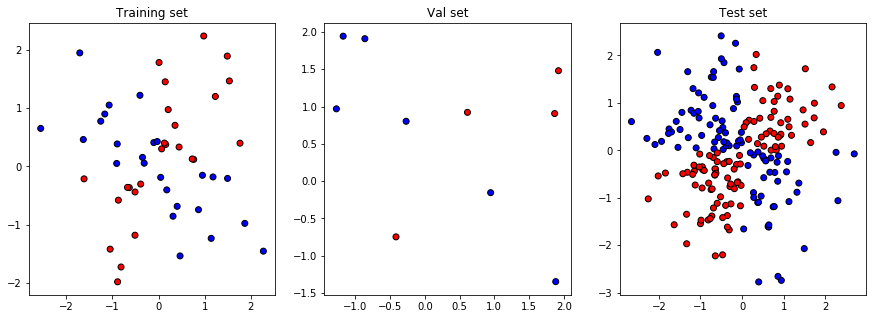

In [540]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.title('Training set')
plt.scatter(X_train.T[0], X_train.T[1], c=Y_train, cmap=matplotlib.colors.ListedColormap(point_colors), edgecolor='k')

plt.subplot(132)
plt.title('Val set')
plt.scatter(X_val.T[0], X_val.T[1], c=Y_val, cmap=matplotlib.colors.ListedColormap(point_colors), edgecolor='k')

plt.subplot(133)
plt.title('Test set')
plt.scatter(X_test.T[0], X_test.T[1], c=Y_test, cmap=matplotlib.colors.ListedColormap(point_colors), edgecolor='k')

plt.show()

In [541]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from collections import OrderedDict

In [542]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [543]:
class MLP3Layers(nn.Module): 
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP3Layers, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output = F.relu(self.fc1(x))
        output = F.relu(self.fc2(output))
        output = self.out(output)
        return output

In [544]:
nn_model = MLP3Layers(input_size=X_train.shape[1], hidden_size=100, output_size=np.unique(Y_train).size-1).to(device)
optimizer = optim.SGD(nn_model.parameters(), lr=0.01, momentum=0.9)
summary(nn_model, input_size=((1,2)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]             300
            Linear-2               [-1, 1, 100]          10,100
            Linear-3                 [-1, 1, 1]             101
Total params: 10,501
Trainable params: 10,501
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [545]:
batch_size = 10
NUM_EPOCHS = 10
n_batches = int(len(X_train) / batch_size)

In [546]:
X_train_tensor = torch.from_numpy(X_train).float()
Y_train_tensor = torch.from_numpy(Y_train*1)

In [547]:
# Training our deterministic model 
for epoch in range(NUM_EPOCHS):
    nn_model.train()
    loss, acc, len_steps = 0, 0, 0
    loop = tqdm(range(n_batches))
    for i in loop:
        data, target = X_train_tensor[i*batch_size:(i+1)*batch_size,].to(device), Y_train_tensor[i*batch_size:(i+1)*batch_size,].to(device)
        optimizer.zero_grad()
        output = nn_model(data)
        current_loss = nn.BCEWithLogitsLoss()(output.squeeze(), target.float())
        current_loss.backward()
        loss += current_loss
        optimizer.step()
        len_steps += len(data)
        
        pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        acc += pred.eq(target.view_as(pred)).sum().item()

        #update the average loss
        loop.set_description('Epoch {}/{}'.format(epoch + 1, NUM_EPOCHS))
        loop.set_postfix(OrderedDict({'loss':'{:05.3f}'.format(loss / float(len_steps)), 
                                      'acc':'{:05.3f}'.format(acc / float(len_steps))}))
        loop.update()

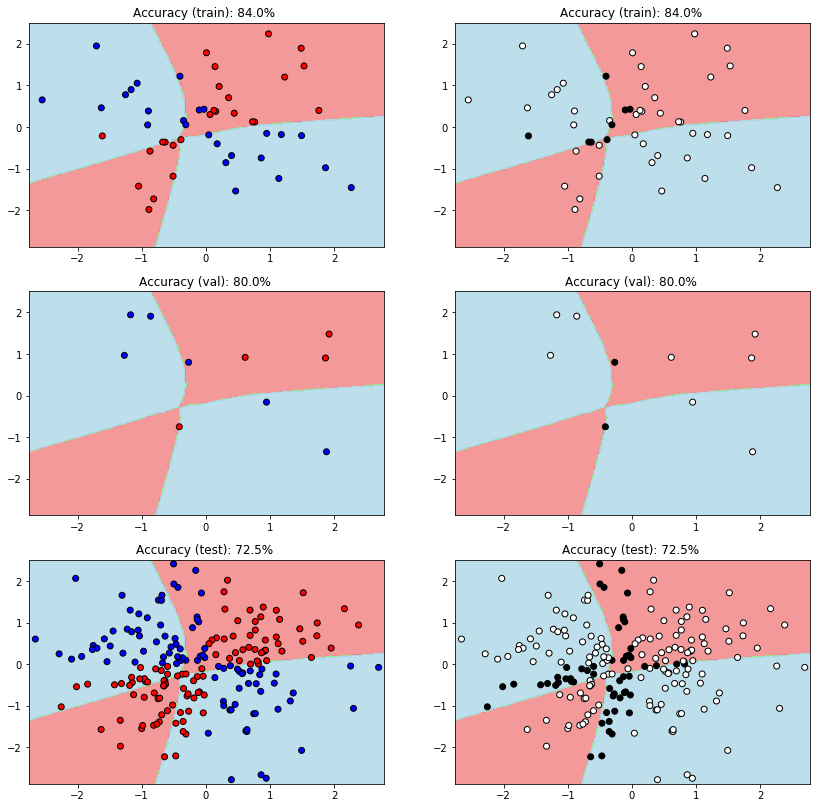

In [548]:
# Linspace for imshow plot
extend = (min(X_train[:,0].min(),X_test[:,0].min())-0.1, max(X_train[:,0].max(),X_test[:,0].max())+0.1, 
          min(X_train[:,1].min(),X_test[:,1].min())-0.1, max(X_train[:,1].max(),X_test[:,1].max())+0.1, )

xx, yy = np.meshgrid(np.arange(extend[0], extend[1], 0.02),
                         np.arange(extend[2], extend[3], 0.02))
Xfull = np.c_[xx.ravel(), yy.ravel()]
Yfull = np.logical_xor(Xfull[:, 0] > 0, Xfull[:, 1] > 0)

plt.figure(figsize=(14, 14))

nn_model.eval()
output_train = nn_model(torch.from_numpy(X_train).float().to(device)).detach().cpu().numpy()
Y_pred_train = (sigmoid(output_train)>=0.5).reshape(-1)

output_val = nn_model(torch.from_numpy(X_val).float().to(device)).detach().cpu().numpy()
Y_pred_val = (sigmoid(output_val)>=0.5).reshape(-1)

nn_model.eval()
output_pred = nn_model(torch.from_numpy(X_test).float().to(device)).detach().cpu().numpy()
Y_pred = (sigmoid(output_pred)>=0.5).reshape(-1)
probas_pred = (sigmoid(output_pred)*Y_pred.reshape(-1,1)+(1-sigmoid(output_pred))*(1-Y_pred.reshape(-1,1))).reshape(-1)
accuracy = accuracy_score(Y_test, Y_pred)

output_Z = nn_model(torch.from_numpy(Xfull).float().to(device)).detach().cpu().numpy()
Z = (sigmoid(output_Z)>=0.5)
probas_Z = (sigmoid(output_Z)*Z+(1-sigmoid(output_Z))*(1-Z)).reshape(-1)

plt.subplot(321)
plt.title("Accuracy (train): %0.1f%% " % (accuracy_score(Y_train, Y_pred_train) * 100))
plt.contourf(xx, yy, Z.reshape(xx.shape), cmap=matplotlib.colors.ListedColormap(light_colors), alpha=0.8)
plt.scatter(X_train.T[0], X_train.T[1], c=Y_train, cmap=matplotlib.colors.ListedColormap(point_colors), edgecolor='k')

plt.subplot(322)
plt.title("Accuracy (train): %0.1f%% " % (accuracy_score(Y_train, Y_pred_train) * 100))
plt.contourf(xx, yy, Z.reshape(xx.shape), cmap=matplotlib.colors.ListedColormap(light_colors), alpha=0.8)
plt.scatter(X_train.T[0], X_train.T[1], c=(Y_train==Y_pred_train), cmap=matplotlib.colors.ListedColormap(['black', 'white']), edgecolor='k')

plt.subplot(323)
plt.title("Accuracy (val): %0.1f%% " % (accuracy_score(Y_val, Y_pred_val) * 100))
plt.contourf(xx, yy, Z.reshape(xx.shape), cmap=matplotlib.colors.ListedColormap(light_colors), alpha=0.8)
plt.scatter(X_val.T[0], X_val.T[1], c=Y_val, cmap=matplotlib.colors.ListedColormap(point_colors), edgecolor='k')

plt.subplot(324)
plt.title("Accuracy (val): %0.1f%% " % (accuracy_score(Y_val, Y_pred_val) * 100))
plt.contourf(xx, yy, Z.reshape(xx.shape), cmap=matplotlib.colors.ListedColormap(light_colors), alpha=0.8)
plt.scatter(X_val.T[0], X_val.T[1], c=(Y_val==Y_pred_val), cmap=matplotlib.colors.ListedColormap(['black', 'white']), edgecolor='k')


plt.subplot(325)
plt.title("Accuracy (test): %0.1f%% " % (accuracy * 100))
plt.contourf(xx, yy, Z.reshape(xx.shape), cmap=matplotlib.colors.ListedColormap(light_colors), alpha=0.8)
plt.scatter(X_test.T[0], X_test.T[1], c=Y_test, cmap=matplotlib.colors.ListedColormap(point_colors), edgecolor='k')

plt.subplot(326)
plt.title("Accuracy (test): %0.1f%% " % (accuracy * 100))
plt.contourf(xx, yy, Z.reshape(xx.shape), cmap=matplotlib.colors.ListedColormap(light_colors), alpha=0.8)
plt.scatter(X_test.T[0], X_test.T[1], c=(Y_test==Y_pred), cmap=matplotlib.colors.ListedColormap(['black', 'white']), edgecolor='k')

plt.show()

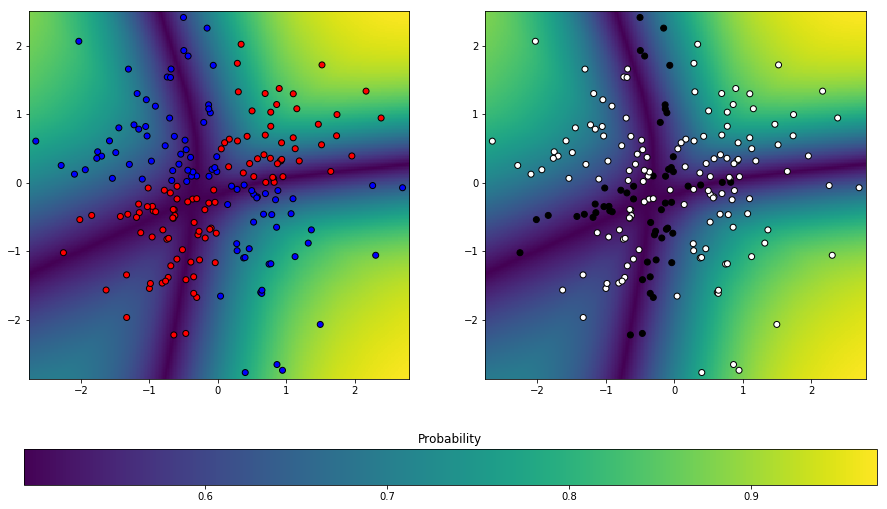

In [549]:
plt.figure(figsize=(15, 10))

plt.subplot(121)
imshow_handle = plt.imshow(probas_Z.reshape(xx.shape), extent=extend, origin='lower')
plt.scatter(X_test.T[0], X_test.T[1], c=Y_test, cmap=matplotlib.colors.ListedColormap(point_colors), edgecolor='k')

plt.subplot(122)
imshow_handle = plt.imshow(probas_Z.reshape(xx.shape), extent=extend, origin='lower')
plt.scatter(X_test.T[0], X_test.T[1], c=(Y_test==Y_pred), cmap=matplotlib.colors.ListedColormap(['black', 'white']), edgecolor='k')

ax = plt.axes([0.12, 0.10, 0.79, 0.05])
plt.title("Probability")
plt.colorbar(imshow_handle, cax=ax, orientation='horizontal')
plt.show()

In [550]:
meshgrid_probas_true = (sigmoid(output_Z)*Yfull.reshape(-1,1)+(1-sigmoid(output_Z))*(1-Yfull.reshape(-1,1))).reshape(-1)
proba_true_pred = (sigmoid(output_pred)*Y_test.reshape(-1,1)+(1-sigmoid(output_pred))*(1-Y_test.reshape(-1,1))).reshape(-1)

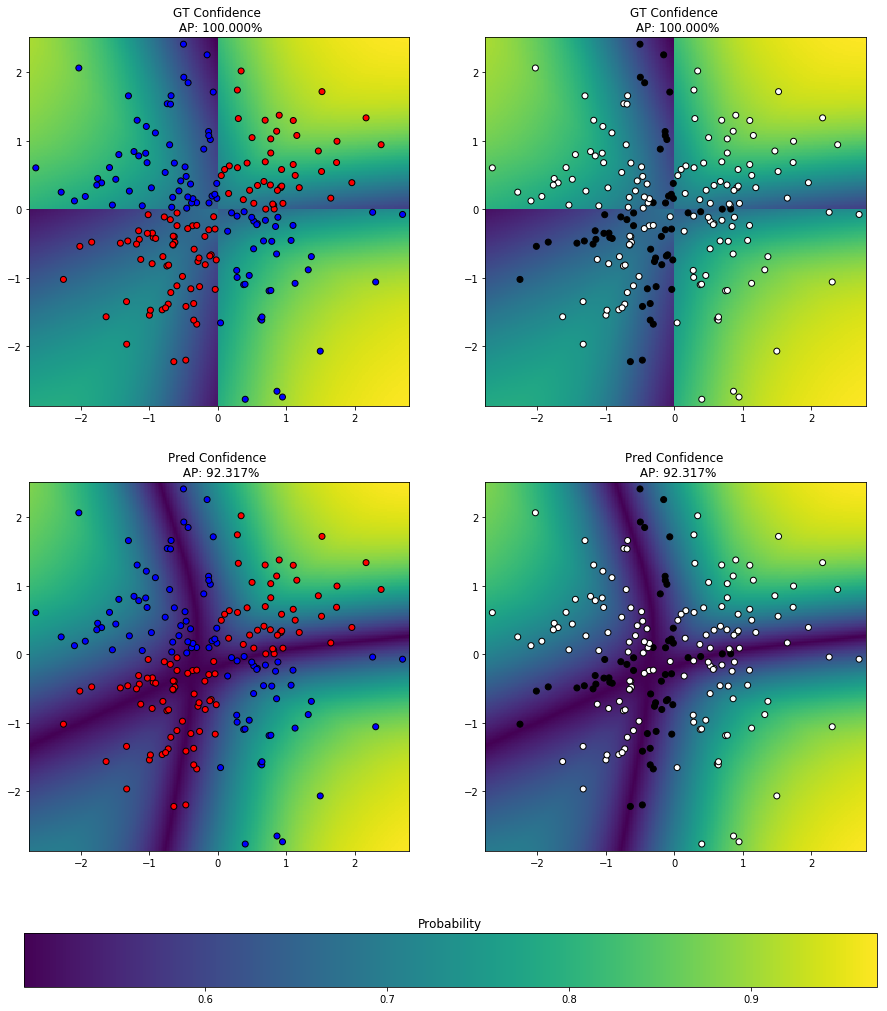

In [551]:
ap_pred = average_precision_score((Y_pred==Y_test),probas_pred)
ap_gt = average_precision_score((Y_pred==Y_test),proba_true_pred)

plt.figure(figsize=(15, 15))

plt.subplot(221)
plt.title('GT Confidence \n AP: {:0.3%}'.format(ap_gt))
plt.imshow(meshgrid_probas_true.reshape(xx.shape), extent=extend, origin='lower')
plt.scatter(X_test.T[0], X_test.T[1], c=Y_test, cmap=matplotlib.colors.ListedColormap(point_colors), edgecolor='k')

plt.subplot(222)
plt.title('GT Confidence \n AP: {:0.3%}'.format(ap_gt))
plt.imshow(meshgrid_probas_true.reshape(xx.shape), extent=extend, origin='lower')
plt.scatter(X_test.T[0], X_test.T[1], c=((Y_pred==Y_test)), cmap=matplotlib.colors.ListedColormap(bayes_colors), edgecolor='k')

plt.subplot(223)
plt.title('Pred Confidence \n AP: {:0.3%}'.format(ap_pred))
imshow_handle = plt.imshow(probas_Z.reshape(xx.shape), extent=extend, origin='lower')
plt.scatter(X_test.T[0], X_test.T[1], c=Y_test, cmap=matplotlib.colors.ListedColormap(point_colors), edgecolor='k')

plt.subplot(224)
plt.title('Pred Confidence \n AP: {:0.3%}'.format(ap_pred))
imshow_handle = plt.imshow(probas_Z.reshape(xx.shape), extent=extend, origin='lower')
plt.scatter(X_test.T[0], X_test.T[1], c=((Y_pred==Y_test)), cmap=matplotlib.colors.ListedColormap(bayes_colors), edgecolor='k')


ax = plt.axes([0.12, 0., 0.79, 0.05])
plt.title("Probability")
plt.colorbar(imshow_handle, cax=ax, orientation='horizontal')
plt.show()

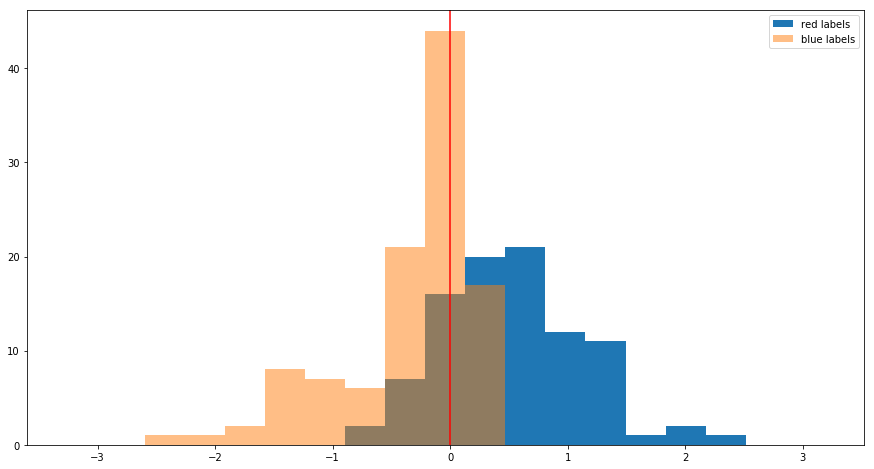

In [574]:
plt.figure(figsize=(15,8))
plt.hist(output_pred[np.where(Y_test==1)], bins=np.linspace(output_pred.min()-1, output_pred.max()+1,num=20), label='red labels')
plt.hist(output_pred[np.where(Y_test==0)], bins=np.linspace(output_pred.min()-1, output_pred.max()+1,num=20), alpha=0.5, label='blue labels')
plt.axvline(x=0, color='r')
plt.legend()
plt.show()

In [553]:
from scipy.stats import describe
describe(output_pred)

DescribeResult(nobs=200, minmax=(array([-2.2783456], dtype=float32), array([2.196724], dtype=float32)), mean=array([0.06592035], dtype=float32), variance=array([0.5110781], dtype=float32), skewness=array([-0.16831374], dtype=float32), kurtosis=array([0.95765233], dtype=float32))

In [563]:
class MLPConfidence(nn.Module): 
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPConfidence, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.uncertainty1   = nn.Linear(hidden_size, 16*5*5)
        self.uncertainty2   = nn.Linear(16*5*5, 120)
        self.uncertainty3   = nn.Linear(120, 84)
        self.uncertainty4   = nn.Linear(84, 1)
        
    def forward(self, x):
        output = F.relu(self.fc1(x))
        output = F.relu(self.fc2(output))
        pred = self.out(output)
        uncertainty = F.relu(self.uncertainty1(output))
        uncertainty = F.relu(self.uncertainty2(uncertainty))
        uncertainty = F.relu(self.uncertainty3(uncertainty))
        uncertainty = self.uncertainty4(uncertainty)
        return pred, torch.sigmoid(uncertainty)

In [565]:
confidence_model = MLPConfidence(input_size=X_val.shape[1], hidden_size=100, output_size=np.unique(Y_val).size-1).to(device)
confidence_model.load_state_dict(nn_model.state_dict(), strict=False)
optimizer = optim.SGD(confidence_model.parameters(), lr=0.01, momentum=0.9)
summary(confidence_model, input_size=((1,2)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]             300
            Linear-2               [-1, 1, 100]          10,100
            Linear-3                 [-1, 1, 1]             101
            Linear-4               [-1, 1, 400]          40,400
            Linear-5               [-1, 1, 120]          48,120
            Linear-6                [-1, 1, 84]          10,164
            Linear-7                 [-1, 1, 1]              85
Total params: 109,270
Trainable params: 109,270
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.42
Estimated Total Size (MB): 0.42
----------------------------------------------------------------


In [566]:
# Freezing layers
for param in confidence_model.named_parameters():
    if 'uncertainty' in param[0]:
        print ('{} kept to training'.format(param[0]))
        continue
    param[1].requires_grad = False

uncertainty1.weight kept to training
uncertainty1.bias kept to training
uncertainty2.weight kept to training
uncertainty2.bias kept to training
uncertainty3.weight kept to training
uncertainty3.bias kept to training
uncertainty4.weight kept to training
uncertainty4.bias kept to training


In [368]:
class WeightedAutoConfidenceLoss(nn.modules.loss._Loss):
    def __init__(self, device, num_classes, lbda_1=0, lbda_2=1):
        self.device = device
        self.nb_classes = num_classes
        self.lbda_1 = lbda_1
        self.lbda_2 = lbda_2
        super(WeightedAutoConfidenceLoss, self).__init__()

    def forward(self, input, target, weighting=1.):
        self.loss_nll = nn.BCEWithLogitsLoss()(input[0],target)
        probs = torch.sigmoid(input[0])
        weights = torch.ones_like(target).type(torch.FloatTensor).to(self.device)
        weights[(probs.argmax(dim=1)!=target)]*=weighting
        labels_hot = torch.eye(self.nb_classes)[target].to(self.device)
        weighted_out = weights*(input[1].view(-1)-(probs*labels_hot).sum(dim=1))**2
        self.loss_mse = weighted_out.mean(0)
        return self.loss_nll*self.lbda_1+self.loss_mse*self.lbda_2
    
confidence_loss = WeightedAutoConfidenceLoss(device, 2)

In [375]:
# Training our deterministic model 
X_val_tensor = torch.from_numpy(X_val).float()
Y_val_tensor = torch.from_numpy(Y_val*1)
n_batches_val = int(len(X_val) / batch_size)

for epoch in range(100):
    confidence_model.train()
    loss, nll_loss, mse_loss = 0,0,0
    accuracy = 0
    len_steps = 0
    loop = tqdm(range(n_batches))
    for i in loop:
        data, target = X_train_tensor[i*batch_size:(i+1)*batch_size,].to(device), Y_train_tensor[i*batch_size:(i+1)*batch_size,].to(device)
        optimizer.zero_grad()
        output = confidence_model(data)
        current_loss = confidence_loss(output, target)
        current_loss.backward()
        loss += current_loss
        nll_loss += confidence_loss.loss_nll
        mse_loss += confidence_loss.loss_mse
        optimizer.step()
        len_steps += len(data)
        
        pred = output[0].argmax(dim=1, keepdim=True)
        accuracy += pred.eq(target.view_as(pred)).sum()

        # Update the average loss
        loop.set_description('Epoch {}/{}'.format(epoch, 30))
        loop.set_postfix(OrderedDict({'loss':'{:05.3f}'.format(loss / float(len_steps)), 
            'nll_loss':'{:05.3e}'.format(nll_loss / float(len_steps)), 
            'mse_loss':'{:05.3e}'.format(mse_loss / float(len_steps)),
            'acc':'{:05.2%}'.format(accuracy.item() / float(len_steps))}))
        loop.update()

In [376]:
confidence_model.eval()
_, probas_confidence = confidence_model(torch.from_numpy(X_test).float().to(device))
_, meshgrid_probas_ours = confidence_model(torch.from_numpy(Xfull).float().to(device))

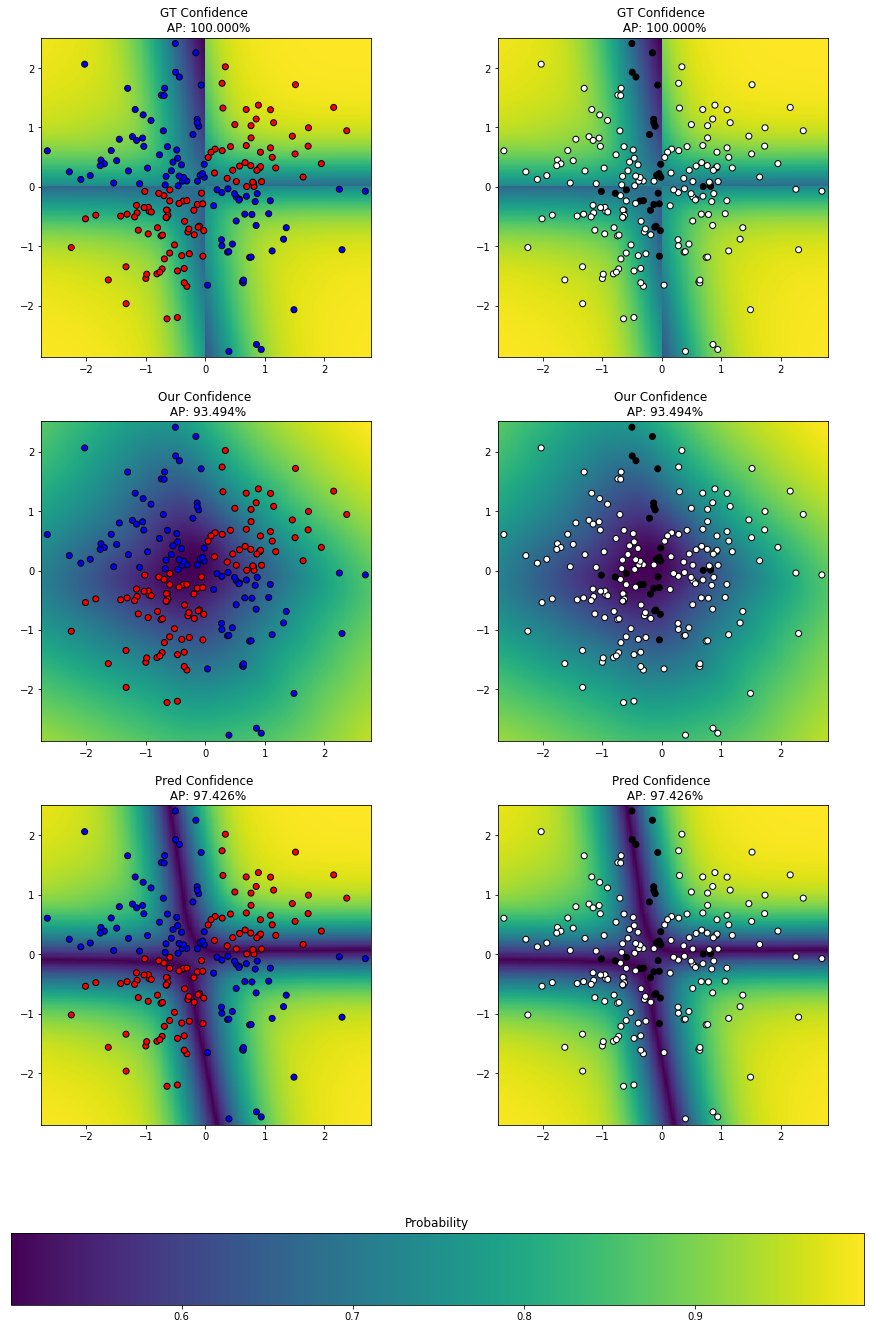

In [377]:
ap_ours = average_precision_score((Y_pred==Y_test),probas_confidence.to('cpu').detach().numpy())

plt.figure(figsize=(15, 20))

plt.subplot(321)
plt.title('GT Confidence \n AP: {:0.3%}'.format(ap_gt))
plt.imshow(meshgrid_probas_true.reshape(xx.shape), extent=extend, origin='lower')
plt.scatter(X_test.T[0], X_test.T[1], c=Y_test, cmap=matplotlib.colors.ListedColormap(point_colors), edgecolor='k')

plt.subplot(322)
plt.title('GT Confidence \n AP: {:0.3%}'.format(ap_gt))
plt.imshow(meshgrid_probas_true.reshape(xx.shape), extent=extend, origin='lower')
plt.scatter(X_test.T[0], X_test.T[1], c=((Y_pred==Y_test)), cmap=matplotlib.colors.ListedColormap(bayes_colors), edgecolor='k')

plt.subplot(323)
plt.title('Our Confidence \n AP: {:0.3%}'.format(ap_ours))
imshow_handle = plt.imshow(meshgrid_probas_ours.to('cpu').detach().numpy().reshape(xx.shape), extent=extend, origin='lower')
plt.scatter(X_test.T[0], X_test.T[1], c=Y_test, cmap=matplotlib.colors.ListedColormap(point_colors), edgecolor='k')

plt.subplot(324)
plt.title('Our Confidence \n AP: {:0.3%}'.format(ap_ours))
imshow_handle = plt.imshow(meshgrid_probas_ours.to('cpu').detach().numpy().reshape(xx.shape), extent=extend, origin='lower')
plt.scatter(X_test.T[0], X_test.T[1], c=((Y_pred==Y_test)), cmap=matplotlib.colors.ListedColormap(bayes_colors), edgecolor='k')

plt.subplot(325)
plt.title('Pred Confidence \n AP: {:0.3%}'.format(ap_pred))
imshow_handle = plt.imshow(output_Z.max(dim=1)[0].to('cpu').detach().numpy().reshape(xx.shape), extent=extend, origin='lower')
plt.scatter(X_test.T[0], X_test.T[1], c=Y_test, cmap=matplotlib.colors.ListedColormap(point_colors), edgecolor='k')

plt.subplot(326)
plt.title('Pred Confidence \n AP: {:0.3%}'.format(ap_pred))
imshow_handle = plt.imshow(output_Z.max(dim=1)[0].to('cpu').detach().numpy().reshape(xx.shape), extent=extend, origin='lower')
plt.scatter(X_test.T[0], X_test.T[1], c=((Y_pred==Y_test)), cmap=matplotlib.colors.ListedColormap(bayes_colors), edgecolor='k')

ax = plt.axes([0.12, 0., 0.79, 0.05])
plt.title("Probability")
plt.colorbar(imshow_handle, cax=ax, orientation='horizontal')
plt.show()

# Toy dataset 3 : Linear

In [132]:
gaussian_linear1= multivariate_normal([0, 2], [[1, 0], [0, 1]])
gaussian_linear2= multivariate_normal([5, 2], [[1, 0], [0, 1]])
gaussian_linear3 = multivariate_normal([15, 2], [[1, 0], [0, 1]])

gaussians_linear = [gaussian_linear1, gaussian_linear2, gaussian_linear3]

TRAINING_SAMPLES = np.array([50,50,5])
TEST_SAMPLES = np.array([100,100,100])

In [133]:
# Generate training set
X_train = np.zeros((TRAINING_SAMPLES.sum(),2))
Y_train = np.zeros((TRAINING_SAMPLES.sum()))
cur = 0
for i,g in enumerate(gaussians_linear):
    X_train[cur:cur+TRAINING_SAMPLES[i],:] = g.rvs(size=TRAINING_SAMPLES[i])
    Y_train[cur:cur+TRAINING_SAMPLES[i]] = np.ones(TRAINING_SAMPLES[i])*(i%2)
    cur += TRAINING_SAMPLES[i]

In [134]:
# Generate test set
X_test = np.zeros((TEST_SAMPLES.sum(),2))
Y_test = np.zeros((TEST_SAMPLES.sum()))
cur = 0
for i,g in enumerate(gaussians_linear):
    X_test[cur:cur+TEST_SAMPLES[i],:] = g.rvs(size=TEST_SAMPLES[i])
    Y_test[cur:cur+TEST_SAMPLES[i]] = np.ones(TEST_SAMPLES[i])*(i%2)
    cur += TEST_SAMPLES[i]

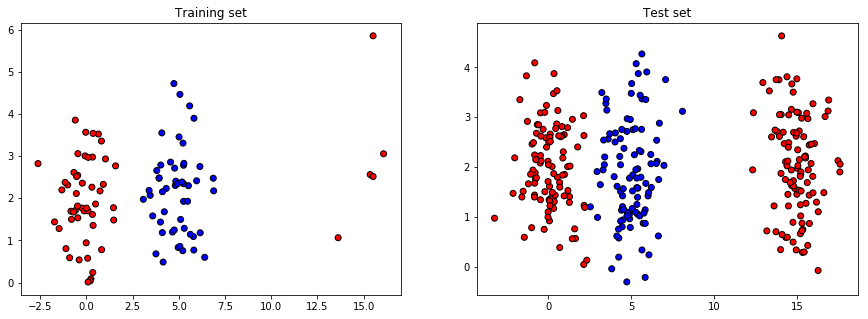

In [135]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.title('Training set')
plt.scatter(X_train.T[0], X_train.T[1], c=Y_train, cmap=matplotlib.colors.ListedColormap(point_colors), edgecolor='k')

plt.subplot(122)
plt.title('Test set')
plt.scatter(X_test.T[0], X_test.T[1], c=Y_test, cmap=matplotlib.colors.ListedColormap(point_colors), edgecolor='k')

plt.show()

In [136]:
classifier = LogisticRegression(random_state=0, solver='lbfgs',  multi_class='multinomial').fit(X_train, Y_train)

Accuracy classifier: 65.7% 


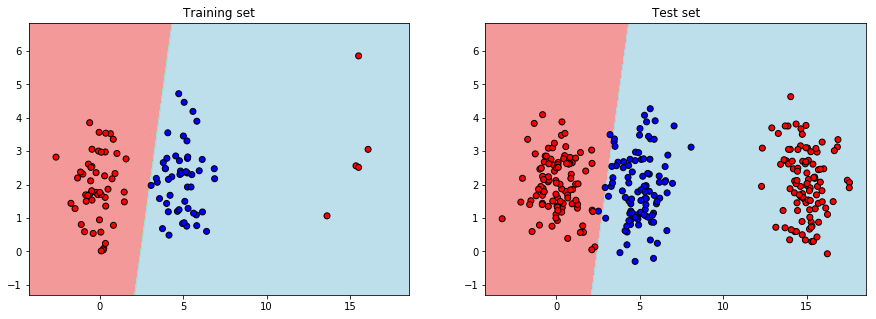

In [137]:
# Linspace for imshow plot
extend = (min(X_train[:,0].min(),X_test[:,0].min())-1, max(X_train[:,0].max(),X_test[:,0].max())+1, 
          min(X_train[:,1].min(),X_test[:,1].min())-1, max(X_train[:,1].max(),X_test[:,1].max())+1, )
xx, yy = np.meshgrid(np.arange(extend[0], extend[1], 0.02),
                         np.arange(extend[2], extend[3], 0.02))
Xfull = np.c_[xx.ravel(), yy.ravel()]

# Classifier
Z = classifier.predict(Xfull)
Z = Z.reshape(xx.shape)

Y_pred = classifier.predict(X_test)
probas_pred = classifier.predict_proba(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy classifier: %0.1f%% " % (accuracy * 100))


plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.title('Training set')
plt.contourf(xx, yy, Z, cmap=matplotlib.colors.ListedColormap(light_colors), alpha=0.8)
plt.scatter(X_train.T[0], X_train.T[1], c=Y_train, cmap=matplotlib.colors.ListedColormap(point_colors), edgecolor='k')

plt.subplot(122)
plt.title('Test set')
plt.contourf(xx, yy, Z, cmap=matplotlib.colors.ListedColormap(light_colors), alpha=0.8)
plt.scatter(X_test.T[0], X_test.T[1], c=Y_test, cmap=matplotlib.colors.ListedColormap(point_colors), edgecolor='k')

plt.show()

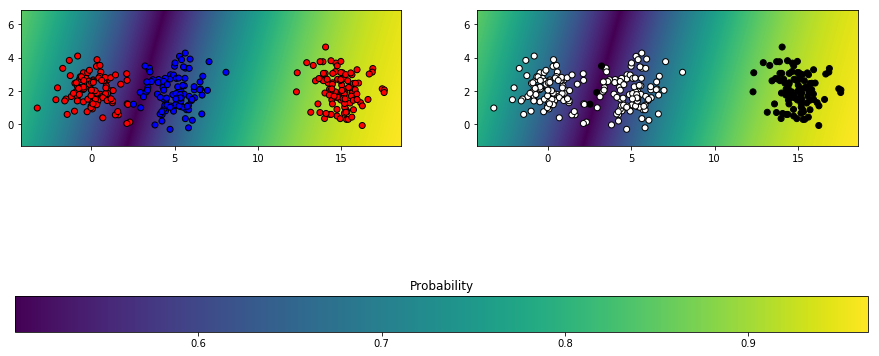

In [138]:
probas_grid = classifier.predict_proba(Xfull)

plt.figure(figsize=(15, 10))

plt.subplot(121)
imshow_handle = plt.imshow(probas_grid.max(axis=1).reshape(xx.shape), extent=extend, origin='lower')
plt.scatter(X_test.T[0], X_test.T[1], c=Y_test, cmap=matplotlib.colors.ListedColormap(point_colors), edgecolor='k')

plt.subplot(122)
plt.imshow(probas_grid.max(axis=1).reshape(xx.shape), extent=extend, origin='lower')
plt.scatter(X_test.T[0], X_test.T[1], c=(Y_pred==Y_test), cmap=matplotlib.colors.ListedColormap(['black','white']), edgecolor='k')

ax = plt.axes([0.12, 0.15, 0.79, 0.05])
plt.title("Probability")
plt.colorbar(imshow_handle, cax=ax, orientation='horizontal')
plt.show()

In [139]:
class ConfidenceRegressor(nn.Module): 
    def __init__(self, input_size, hidden_size, output_size):
        super(ConfidenceRegressor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output = F.relu(self.fc1(x))
        output = F.relu(self.fc2(output))
        output = self.out(output)
        return torch.sigmoid(output)

In [140]:
confidence_model = ConfidenceRegressor(input_size=X_train.shape[1], hidden_size=100, output_size=np.unique(Y_train).size-1).to(device)
optimizer = optim.SGD(confidence_model.parameters(), lr=0.01, momentum=0.9)
summary(confidence_model, input_size=((1,2)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]             300
            Linear-2               [-1, 1, 100]          10,100
            Linear-3                 [-1, 1, 1]             101
Total params: 10,501
Trainable params: 10,501
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [141]:
batch_size = 10
NUM_EPOCHS = 30
n_batches = int(len(X_train) / batch_size)

X_train_tensor, Y_train_tensor = shuffle(X_train, Y_train)
probas_pred_train = classifier.predict_proba(X_train_tensor)
X_train_tensor = torch.from_numpy(X_train_tensor).float()
Y_train_tensor = torch.from_numpy(np.choose(Y_train_tensor.astype(int),probas_pred_train.T))

# Training our deterministic model 
for epoch in range(NUM_EPOCHS):
    confidence_model.train()
    loss, acc, len_steps = 0, 0, 0
    loop = tqdm(range(n_batches))
    for i in loop:
        data, target = X_train_tensor[i*batch_size:(i+1)*batch_size,].to(device), Y_train_tensor[i*batch_size:(i+1)*batch_size,].to(device)
        optimizer.zero_grad()
        output = confidence_model(data)
        current_loss = nn.MSELoss()(output.view(-1), target.float())
        current_loss.backward()
        loss += current_loss
        optimizer.step()
        len_steps += len(data)

        #update the average loss
        loop.set_description('Epoch {}/{}'.format(epoch + 1, NUM_EPOCHS))
        loop.set_postfix(OrderedDict({'loss':'{:05.3e}'.format(loss / float(len_steps))}))
        loop.update()

In [142]:
confidence_model.eval()
probas_confidence = confidence_model(torch.from_numpy(X_test).float().to(device))
meshgrid_probas_ours = confidence_model(torch.from_numpy(Xfull).float().to(device))

In [143]:
# Optimal bayes
proba_bayes, Z_bayes = optimal_bayes(Xfull, gaussians_linear)
proba_test_bayes, Y_bayes = optimal_bayes(X_test, gaussians_linear)
meshgrid_probas_true = np.choose(Z_bayes%2, probas_grid.T)

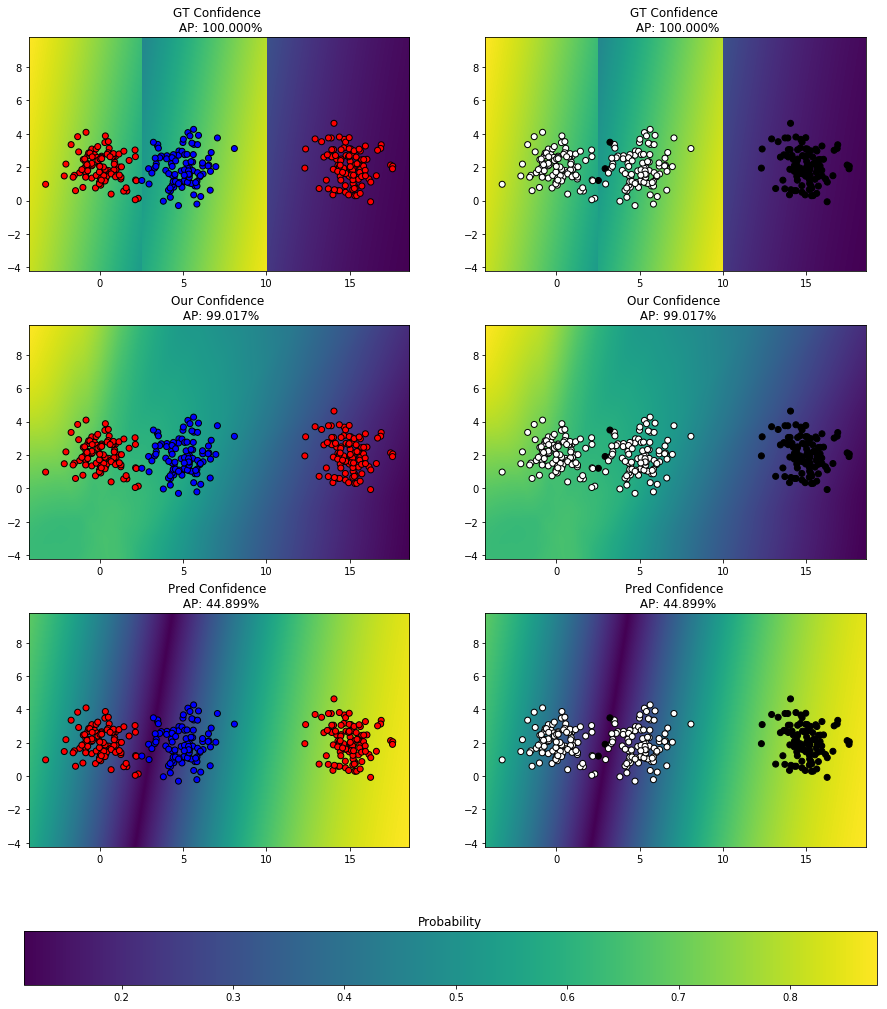

In [144]:
ap_pred = average_precision_score((Y_pred==Y_test),probas_pred.max(axis=1))
ap_gt = average_precision_score((Y_pred==Y_test),np.choose(Y_bayes%2, probas_pred.T))
ap_ours = average_precision_score((Y_pred==Y_test),probas_confidence.to('cpu').detach().numpy())

extend = (min(X_train[:,0].min(),X_test[:,0].min())-1, max(X_train[:,0].max(),X_test[:,0].max())+1, 
          min(X_train[:,0].min(),X_test[:,0].min())-1, 0.5*max(X_train[:,0].max(),X_test[:,0].max())+1, )

plt.figure(figsize=(15, 15))

plt.subplot(321)
plt.title('GT Confidence \n AP: {:0.3%}'.format(ap_gt))
plt.imshow(meshgrid_probas_true.reshape(xx.shape), extent=extend, origin='lower')
plt.scatter(X_test.T[0], X_test.T[1], c=Y_test, cmap=matplotlib.colors.ListedColormap(point_colors), edgecolor='k')

plt.subplot(322)
plt.title('GT Confidence \n AP: {:0.3%}'.format(ap_gt))
plt.imshow(meshgrid_probas_true.reshape(xx.shape), extent=extend, origin='lower')
plt.scatter(X_test.T[0], X_test.T[1], c=((Y_pred==Y_test)), cmap=matplotlib.colors.ListedColormap(bayes_colors), edgecolor='k')

plt.subplot(323)
plt.title('Our Confidence \n AP: {:0.3%}'.format(ap_ours))
imshow_handle = plt.imshow(meshgrid_probas_ours.to('cpu').detach().numpy().reshape(xx.shape), extent=extend, origin='lower')
plt.scatter(X_test.T[0], X_test.T[1], c=Y_test, cmap=matplotlib.colors.ListedColormap(point_colors), edgecolor='k')

plt.subplot(324)
plt.title('Our Confidence \n AP: {:0.3%}'.format(ap_ours))
imshow_handle = plt.imshow(meshgrid_probas_ours.to('cpu').detach().numpy().reshape(xx.shape), extent=extend, origin='lower')
plt.scatter(X_test.T[0], X_test.T[1], c=((Y_pred==Y_test)), cmap=matplotlib.colors.ListedColormap(bayes_colors), edgecolor='k')

plt.subplot(325)
plt.title('Pred Confidence \n AP: {:0.3%}'.format(ap_pred))
plt.imshow(probas_grid.max(axis=1).reshape(xx.shape), extent=extend, origin='lower')
plt.scatter(X_test.T[0], X_test.T[1], c=Y_test, cmap=matplotlib.colors.ListedColormap(point_colors), edgecolor='k')

plt.subplot(326)
plt.title('Pred Confidence \n AP: {:0.3%}'.format(ap_pred))
plt.imshow(probas_grid.max(axis=1).reshape(xx.shape), extent=extend, origin='lower')
plt.scatter(X_test.T[0], X_test.T[1], c=((Y_pred==Y_test)), cmap=matplotlib.colors.ListedColormap(bayes_colors), edgecolor='k')


ax = plt.axes([0.12, 0., 0.79, 0.05])
plt.title("Probability")
plt.colorbar(imshow_handle, cax=ax, orientation='horizontal')
plt.show()